## Análise de Séries Temporais - Taxi de NY

Neste estudo, vamos verificar através de uma série temporal, a previsão de passeios de taxi de Nova Iorque, este algoritmo visa prever a detecção de anomalias em casos de feriados e eventos na cidade, prevendo o quanto as pessoas irão utilizar os veículos nos próximos meses.

In [ ]:
import pandas as pd

data = pd.read_csv('/content/dataset.csv', index_col=0)

data.head()


,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 499.9+ KB


In [ ]:
#Convertendo para um objeto de data
data['timestamp'] = pd.to_datetime(data['timestamp'])

#Inserindo um indice para a data no dataframe
data = data.set_index('timestamp')

data.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [ ]:
#Verificação de null
data.isna().sum()

percent_zeros = (data == 0).mean() * 100
percent_nans = data.isna().mean() * 100

print(f"Percentual de valores zerados: {percent_zeros}%")
print(f"Percentual de valores NaN: {percent_nans}%")

Percentual de valores zerados: value    0.0
dtype: float64%
Percentual de valores NaN: value    0.0
dtype: float64%


<h2> Visualização de dados </h2>

<function matplotlib.pyplot.show(close=None, block=None)>

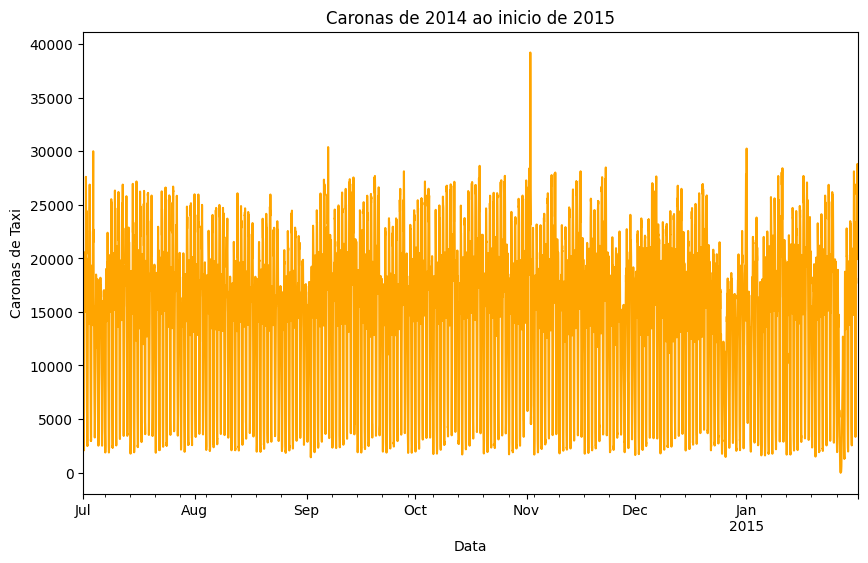

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data['value'].plot(figsize=(10, 6), color='orange')
plt.title('Caronas de 2014 ao inicio de 2015')
plt.xlabel('Data')
plt.ylabel('Caronas de Taxi')
plt.show

## Modelo

O modelo será feito por Long Short-Term Memory (LSTM), pois este tipo de rede neural é eficaz para séries temporais, cujas sequências de dados têm dependência temporal.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

values = data['value'].values

escalador = MinMaxScaler(feature_range=(0, 1))
vl_escalados = escalador.fit_transform(values.reshape(-1,1))

# Hora de treinar
tam_treino = int(len(vl_escalados) * 0.8)
dados_treino = vl_escalados[:tam_treino]
dados_teste = vl_escalados[tam_treino:]

In [ ]:
def create_sequences(data, tam_sequencia):
    X, y = [], []
    for i in range(len(data) - tam_sequencia):
        X.append(data[i:i+tam_sequencia])
        y.append(data[i+tam_sequencia])
    return np.array(X), np.array(y)

In [ ]:
tam_sequencia = 10
X_train, y_train = create_sequences(dados_treino, tam_sequencia)
X_test, y_test = create_sequences(dados_teste, tam_sequencia)

X_train.shape

(8246, 10, 1)

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(tam_sequencia, 1))) #64 = 64 Neurônios, relu = Rectified Linear Unit
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse') #adam ajusta a taxa de aprendizado automaticamente / o MSE penaliza diferenças grandes entre valor previsto e valor real

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(X_train, y_train, epochs=30, batch_size=32)

# Calculo do modelo no conjunto de teste
mse = model.evaluate(X_test, y_test)
print('Erro Quadratico Médio:', mse)

# fazer predições
predictions = model.predict(X_test)

# Inversão das predições em valores reais
predicted_values = escalador.inverse_transform(predictions)
actual_values = escalador.inverse_transform(y_test)

Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0401
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0042
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0026
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0011
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0013
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0010
Epoch 8/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.4756e-04
Epoch 9/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.5274e-04
Epoch 10/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.8446e-04
Epoch 11/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.8765e-04
Epoch 12/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.5822e-04
Epoch 13/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.0471e-04
Epoch 14/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8618e-04
Epoch 15/30
258/258 ━━━━━━━━━

In [ ]:
from sklearn.metrics import r2_score

# Calculando o R²
r2 = r2_score(actual_values, predicted_values)
print('Precisão:', r2)

Precisão: 0.9738319321800317


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


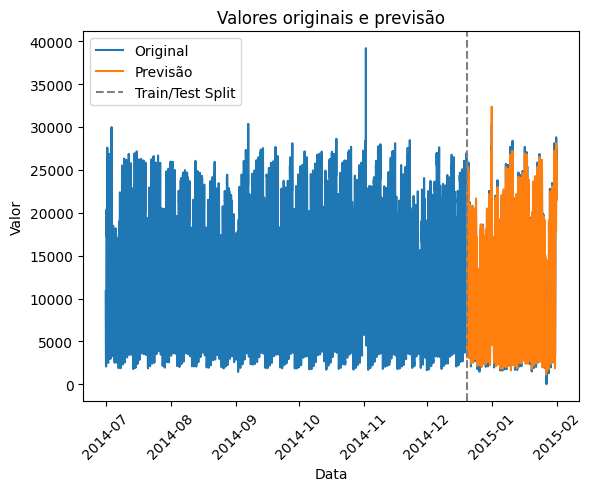

In [ ]:
# Plotting the original values
plt.plot(data, label='Original')

# Plotting the forecasted values

predictions = model.predict(X_train)

plt.plot(data.index[-len(predicted_values):], predicted_values, label='Previsão')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Valores originais e previsão')
plt.axvline(data.index[-len(predicted_values)], color='grey', linestyle='--', label='Train/Test Split')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Colocando mais atributos de tempo para melhor investigação

Plotando o grafico e fazendo um reagrupamento por dia

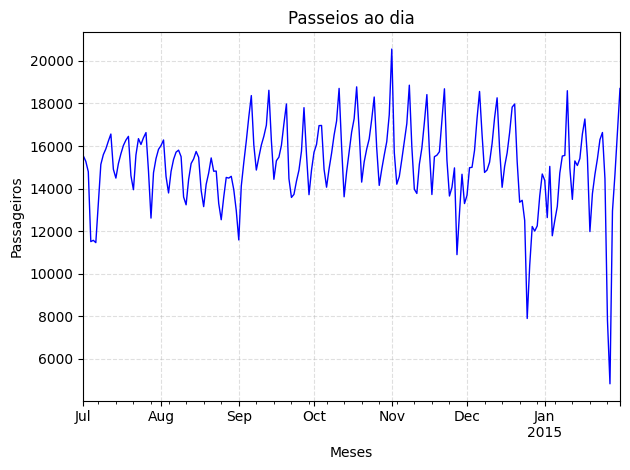

,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667


In [ ]:
df_dia = data['value'].resample('D').mean()
df_dia.plot(linewidth = 1, color = 'blue')
plt.xlabel("Meses")
plt.ylabel("Passageiros")
plt.title("Passeios ao dia")
plt.tight_layout()
plt.grid(linestyle = '--', alpha = 0.4)
plt.show()

df_dia.head()

In [ ]:
data = data.resample('D').mean()

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


ValueError: x and y must have same first dimension, but have shapes (215,) and (2054,)

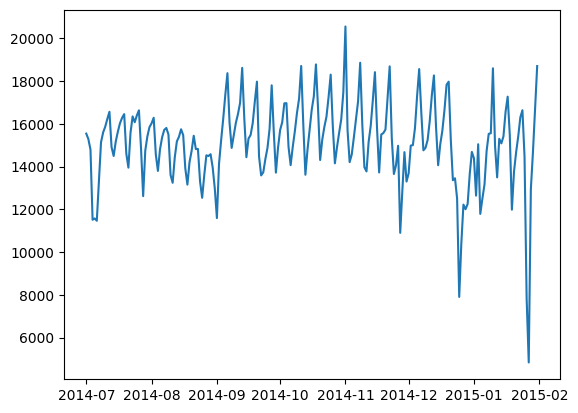

In [ ]:
df = data['value']

# Plotting the original values
plt.plot(df, label='Original')

# Plotting the forecasted values

predictions = model.predict(X_train)

predicted_values = predicted_values.flatten()

plt.plot(data.index[-len(predicted_values):], predicted_values, label='Previsão')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Valores originais e previsão')
plt.axvline(data.index[-len(predicted_values)], color='grey', linestyle='--', label='Train/Test Split')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Verifique se algum valor é zero
zeros = data[data == 0]

# Verifique se algum valor é NaN
nans = data[data.isna()]

print(f"Valores zerados: \n{zeros}")
print(f"Valores NaN: \n{nans}")


In [ ]:
percent_zeros = (data == 0).mean() * 100
percent_nans = data.isna().mean() * 100

print(f"Percentual de valores zerados: {percent_zeros}%")
print(f"Percentual de valores NaN: {percent_nans}%")

Percentual de valores zerados: value    0.0
dtype: float64%
Percentual de valores NaN: value    0.0
dtype: float64%


In [ ]:
values = data['value'].values

escalador = MinMaxScaler(feature_range=(0, 1))
vl_escalados = escalador.fit_transform(values.reshape(-1,1))

# Hora de treinar
tam_treino = int(len(vl_escalados) * 0.8)
dados_treino = vl_escalados[:tam_treino]
dados_teste = vl_escalados[tam_treino:]

In [ ]:
tam_sequencia = 10
X_train, y_train = create_sequences(dados_treino, tam_sequencia)
X_test, y_test = create_sequences(dados_teste, tam_sequencia)

X_train.shape

(162, 10, 1)

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(tam_sequencia, 1))) #64 = 64 Neurônios, relu = Rectified Linear Unit
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse') #adam ajusta a taxa de aprendizado automaticamente / o MSE penaliza diferenças grandes entre valor previsto e valor real

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(X_train, y_train, epochs=30, batch_size=32)

# Calculo do modelo no conjunto de teste
mse = model.evaluate(X_test, y_test)
print('Erro Quadratico Médio:', mse)

# fazer predições
predictions = model.predict(X_test)

# Inversão das predições em valores reais
predicted_values = escalador.inverse_transform(predictions)
actual_values = escalador.inverse_transform(y_test)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0070
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0077
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0073
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0067
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0067
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0086
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0065
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0076
Epoch 14/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081  
Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import mean_squared_error

# Calcular o MSE
mse = mean_squared_error(actual_values, predicted_values)
print("Erro Quadrático Médio (MSE):", mse)


Erro Quadrático Médio (MSE): 5537729.658779823


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


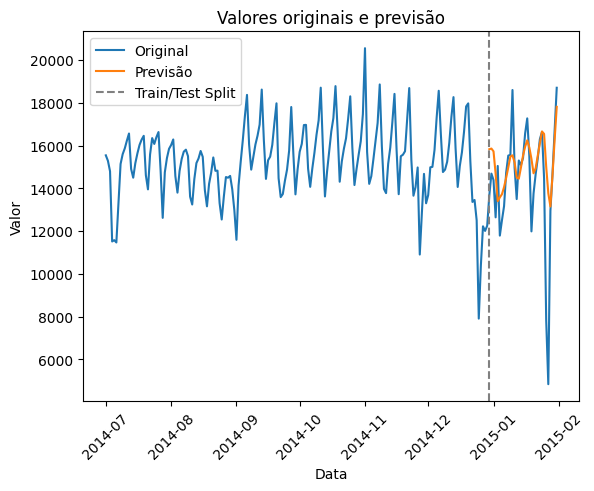

In [ ]:
# Plotting the original values
plt.plot(data, label='Original')

# Plotting the forecasted values

predictions = model.predict(X_train)

plt.plot(data.index[-len(predicted_values):], predicted_values, label='Previsão')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Valores originais e previsão')
plt.axvline(data.index[-len(predicted_values)], color='grey', linestyle='--', label='Train/Test Split')
plt.legend()
plt.xticks(rotation=45)
plt.show()